In [66]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from icecream import ic
import os

In [67]:
class IsingLattice:

    def __init__(self, lattice_size, j1, j2):
        self.lattice_size = lattice_size
        self.num_sites = lattice_size*lattice_size
        self.j1 = j1
        self.j2 = j2

        lattice_state = np.random.randint(2, size=(lattice_size,lattice_size))
        self.lattice_state = np.where(lattice_state==0,-1,1)

    def plot_state(self):
        plt.imshow(self.lattice_state)
        plt.axis("off")

    def flip_spin(self,i,j):
        self.lattice_state[i,j]*= -1

    def print_info(self):
        print("Lattice Size = ",self.lattice_size)
        print("j1 = ",self.j1)
        print("j2 = ",self.j2)
        print("Total number of spins = ",self.num_sites)

    def spin_energy(self,i,j):
        # Define nearest neighbour interaction
        l=self.lattice_size
        spin_ij = self.lattice_state[i,j]
        nearest_up = self.lattice_state[(i-1)%l,j]
        nearest_down = self.lattice_state[(i+1)%l,j]
        nearest_left = self.lattice_state[i,(j-1)%l]
        nearest_right = self.lattice_state[i,(j+1)%l]

        sum_nearest_neighbour = nearest_down + nearest_left + nearest_right + nearest_up

        # Define second nearest neighbour interaction
        right_up = self.lattice_state[(i-1)%l,(j+1)%l]
        right_down = self.lattice_state[(i+1)%l,(j-1)%l]
        left_up = self.lattice_state[(i-1)%l,(j-1)%l]
        left_down = self.lattice_state[(i+1)%l,(j+1)%l]

        sum_second_nearest_neighbour = right_down + right_up + left_down + left_up
        # Define total Ising energy of spin E = j1 * sum(no of nearest neighbour) + j2 * sum(no of second nearest neigbour)
        if self.j2 == 0:
            spin_energy = (-self.j1 * sum_nearest_neighbour * spin_ij)
        else:
            spin_energy = (-self.j1 * sum_nearest_neighbour * spin_ij) + (-self.j2 * sum_second_nearest_neighbour * spin_ij)

        return spin_energy
    
    def total_energy(self):
        #total energy of all spins, but we divide it to no of spins at the end to normalize the energy, we also divide by 2 two to prevent repetition
        total_energy = 0
        for i in range(self.lattice_size):
            for j in range(self.lattice_size):
                total_energy += self.spin_energy(i,j)
        
        return total_energy/2.0/self.num_sites
    
    def spin_mag(self):
    #Magnetization is 1/number of spins * total of spins (include nominal value of state (-1,1))
        return self.lattice_state.sum() / self.num_sites


In [68]:
test_lattice = IsingLattice(30,1,0)
test_lattice.num_sites
test_lattice.print_info()

Lattice Size =  30
j1 =  1
j2 =  0
Total number of spins =  900


2


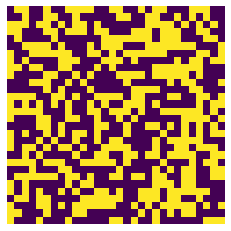

In [69]:
print(test_lattice.spin_energy(1,1))
test_lattice.plot_state()

-2


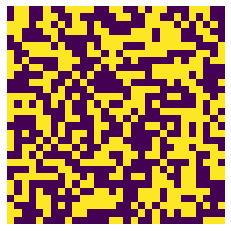

In [70]:
test_lattice.flip_spin(1,1)
test_lattice.plot_state()
print(test_lattice.spin_energy(1,1))

In [71]:
test_lattice.spin_energy(0,1)

0

In [72]:
test_lattice.total_energy()

0.0

In [73]:
print("Energy is",test_lattice.total_energy())
print("Magnetization is",test_lattice.spin_mag())

Energy is 0.0
Magnetization is -0.03333333333333333


In [74]:
#Metropolis Algorithm 
def sweep_lattice(lattice:IsingLattice,T):
    '''
    Scan the lattice once ly, flip the spin if Metropolis criterion holds: if energy<=0 or generated random number<np.exp(-energy_change/temperature)
    '''

    flip_count = 0
    no_flip_count = 0

    for x in range(lattice.num_sites):
        i, j = np.random.randint(lattice.lattice_size, size=2)
        energy_initial = lattice.spin_energy(i,j)
        lattice.flip_spin(i,j)
        energy_flipped = lattice.spin_energy(i,j)
        exchange_energy = energy_flipped - energy_initial
        lattice.flip_spin(i,j)
        if exchange_energy <= 0 or \
            np.random.random()<=np.exp(-exchange_energy/T):
            lattice.flip_spin(i,j)


In [75]:
def thermalize(lattice:IsingLattice,sweep_num,T_hot,T_cold):
    #thermalize dedigimiz iki T arasini yuksek sayida parcaya bolup rate of T change i azaltmak
    for T in np.linspace(T_hot, T_cold, sweep_num):
        sweep_lattice(lattice, T)

In [76]:
thermalize(test_lattice, 10000, 100,3)

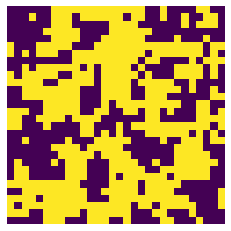

In [77]:
test_lattice.plot_state()

In [78]:
thermalize(test_lattice, 10000, 3,2.5)

KeyboardInterrupt: 

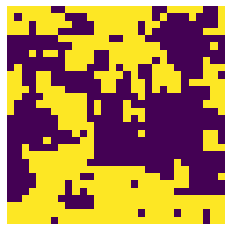

In [ ]:
test_lattice.plot_state()

In [ ]:
thermalize(test_lattice, 10000, 2.5,2.26)

100%|██████████| 10000/10000 [06:19<00:00, 26.33it/s]


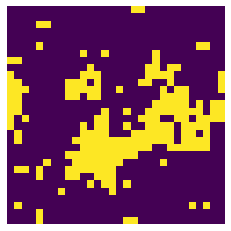

In [ ]:
test_lattice.plot_state()

In [ ]:
thermalize(test_lattice, 10000, 2.26,1.5)

100%|██████████| 10000/10000 [06:32<00:00, 25.45it/s]


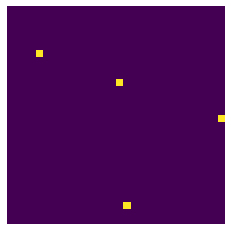

In [ ]:
test_lattice.plot_state()

In [ ]:
def mc_simulation(lattice:IsingLattice, T:np.array, num_sweeps, save_data = True):
    energy = []
    magnetization = []
    lattice_states = []
    file_name = f'L_{lattice.lattice_size}_J1_{lattice.j1:.1f}_J2_{lattice.j2:.3f}'
    os.makedirs(file_name, exist_ok=True)

    thermalize(lattice, 1000, 100, T[0])
    # Get data for T[0]
    sweep_lattice(lattice, T[0])
    energy.append(lattice.total_energy())
    magnetization.append(lattice.spin_mag())
    lattice_states.append(lattice.lattice_state)
   
    if save_data:
        plt.imshow(lattice.lattice_state)
        plt.axis('off')
        plt.savefig(file_name + "/" + file_name + f'_T_{T[0]:.3f}.png')
        plt.close()

    for i in tqdm(range(T.size-1)):
        thermalize(lattice,1000, T[i], T[i+1])
        # Now we want to collect data
        sweep_lattice(lattice, T[i+1])
        energy.append(lattice.total_energy())
        magnetization.append(lattice.spin_mag())
        lattice_states.append(lattice.lattice_state)
        if save_data:
            plt.imshow(lattice.lattice_state)
            plt.axis('off')
            plt.savefig(file_name + "/" +file_name + f'_T_{T[i+1]:.3f}.png')
            plt.close()

    energy = np.asarray(energy)
    magnetization = np.asarray(magnetization)
    lattice_states = np.asarray(lattice_states)
    print('Simulation done.')
    if save_data:
        print('Saving data...')
        np.savetxt(file_name + "/" +file_name + '_energy.txt', energy, delimiter=',')
        np.savetxt(file_name + "/" +file_name + '_magnetization.txt', magnetization, delimiter=',')
    return energy, magnetization, lattice_states

In [ ]:
test_lattice_2 = IsingLattice(30, 1, 0)
T = np.arange(4,0.95,-0.05)

In [ ]:
ene, mag, lat = mc_simulation(test_lattice_2,T,1000, save_data=True)

100%|██████████| 40/40 [54:33<00:00, 81.83s/it]

Simulation done.
Saving data...


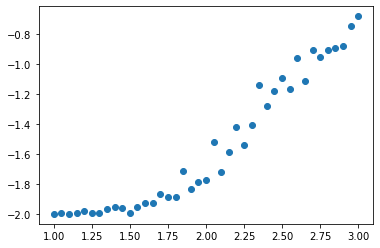

In [ ]:
plt.scatter(T,ene)

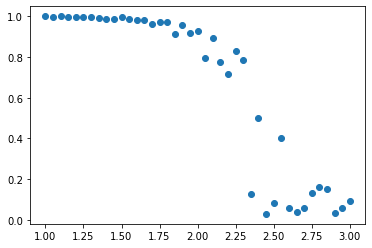

In [ ]:
plt.scatter(T,np.abs(mag))